In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataset = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

C:\Users\foros\Anaconda2\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


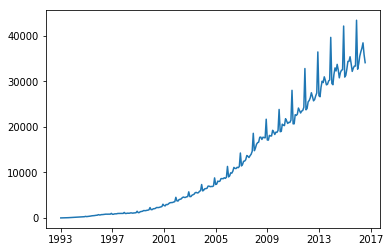

In [3]:
plt.plot(dataset)

In [4]:
# ряд не стационарен. Явно со временем меняется дисперсия, есть тренд и годововая сезонность. Но на всякий случай постоим STL и посчитаем Дика-Фуллера

ДИк-ФУЛЛЕР: 0.991850


<Figure size 1080x720 with 0 Axes>

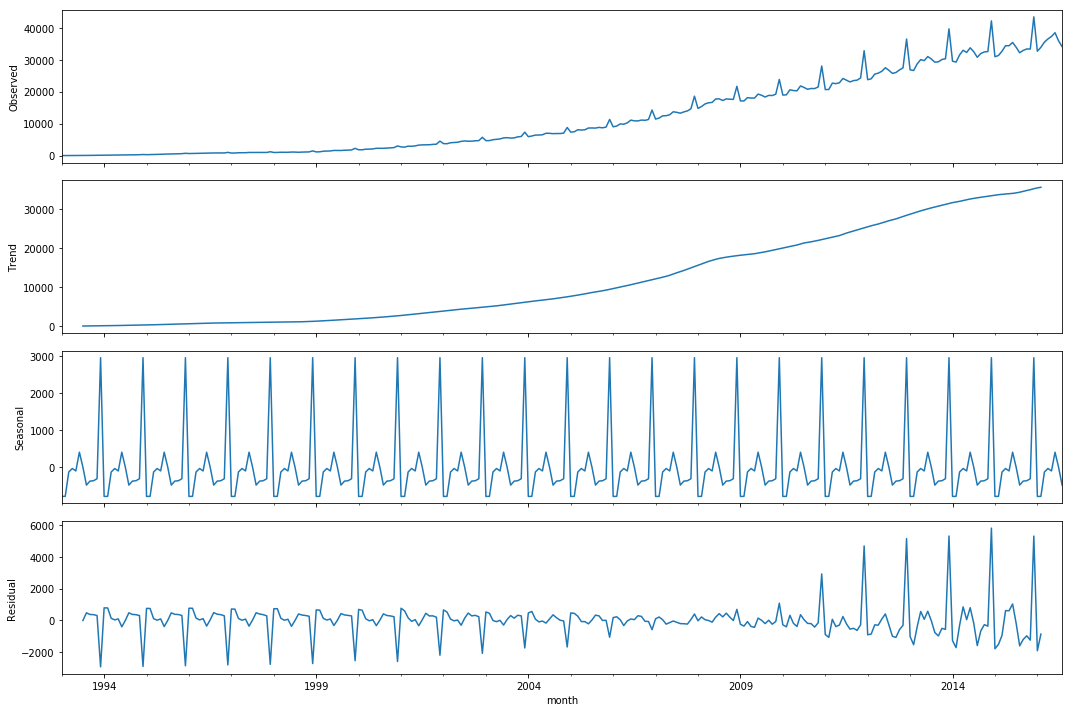

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(dataset.WAG_C_M).plot()
print("ДИк-ФУЛЛЕР: %f" % sm.tsa.stattools.adfuller(dataset.WAG_C_M)[1])

In [6]:
#Попробуем убрать изминение дисперсии Боксом-Коксом:) И применим сезоное диференцирование

In [7]:
dataset['box'], lmbda = stats.boxcox(dataset.WAG_C_M)

In [8]:
dataset['diff'] = dataset.box - dataset.box.shift(12)

In [9]:
#убираем NaN
dataset = dataset.dropna()

In [10]:
sm.tsa.stattools.adfuller(dataset['diff'])

(-3.304078801927452,
 0.014697133494791847,
 6L,
 265L,
 {'1%': -3.4552699038400827,
  '10%': -2.5726152830188678,
  '5%': -2.8725092359464526},
 -11.623584289767962)

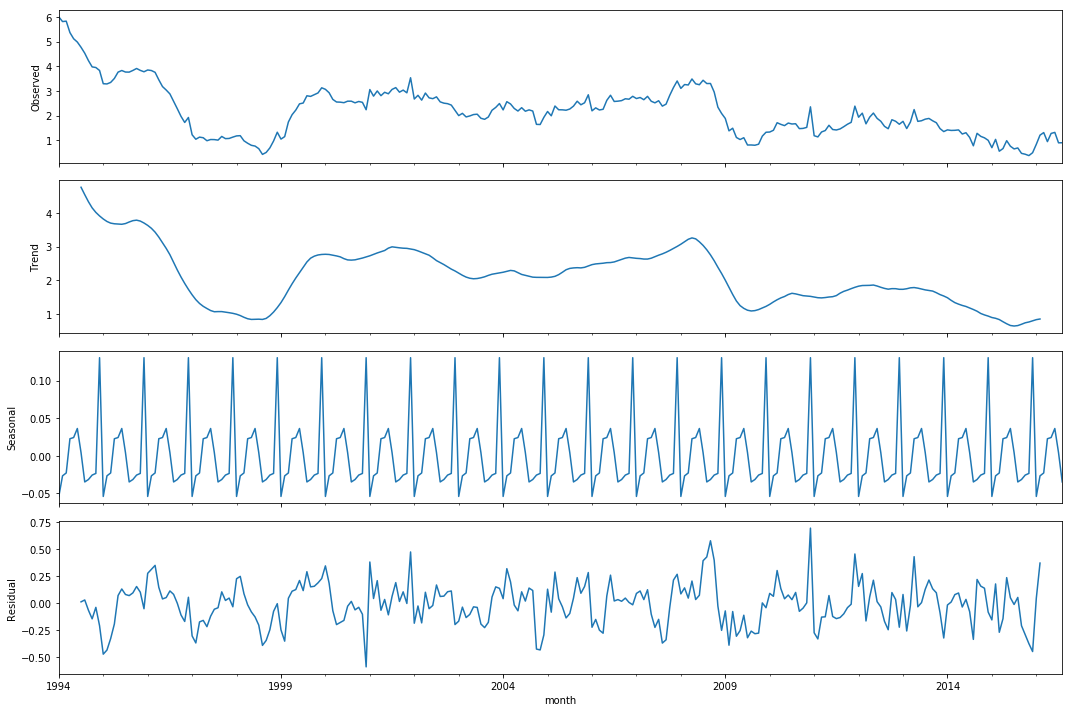

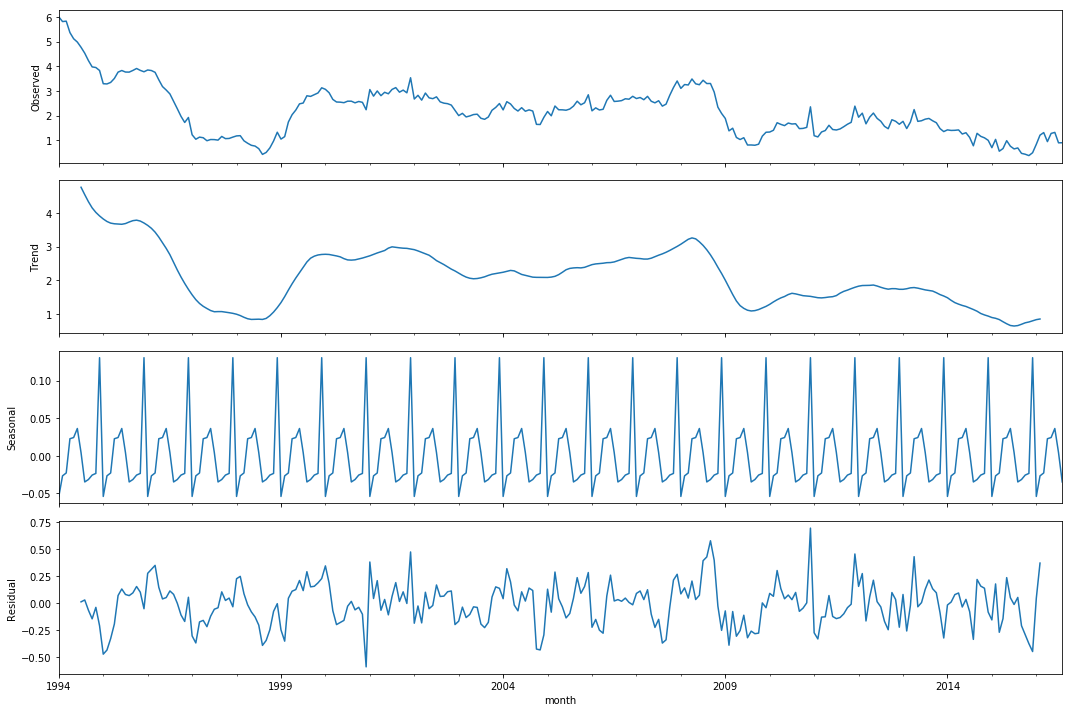

In [11]:
sm.tsa.seasonal_decompose(dataset['diff']).plot() 

In [12]:
#Ряд все еще не стационарен. Несмотря на то, что показатель Дика-Фуллера откланяет гипотизу о нестационарнсти с p=0,015, На STL все еще виден тренд. Попробуем сделать еще одно диференцирование

In [14]:
dataset['diff2'] = dataset['diff'] - dataset['diff'].shift(1)

In [15]:
#убираем NaN
dataset = dataset.dropna()

In [16]:
sm.tsa.stattools.adfuller(dataset['diff2'])

(-6.221729105121905,
 5.203603715821878e-08,
 11L,
 259L,
 {'1%': -3.4558530692911504,
  '10%': -2.572751643088207,
  '5%': -2.872764881778665},
 -4.26999598116646)

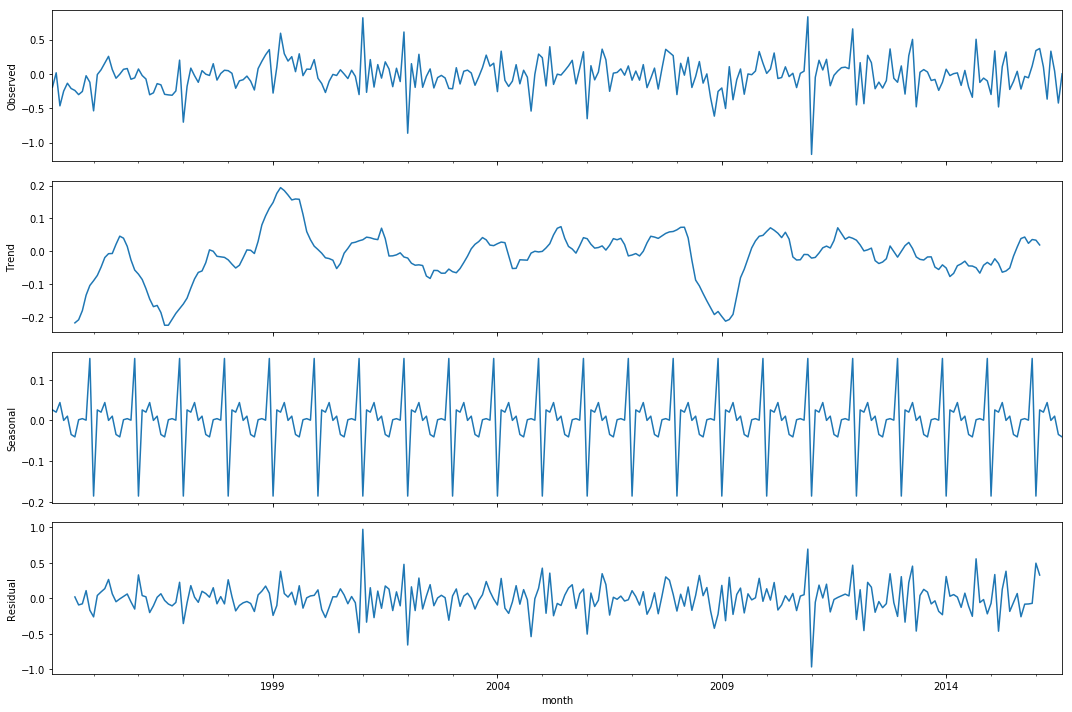

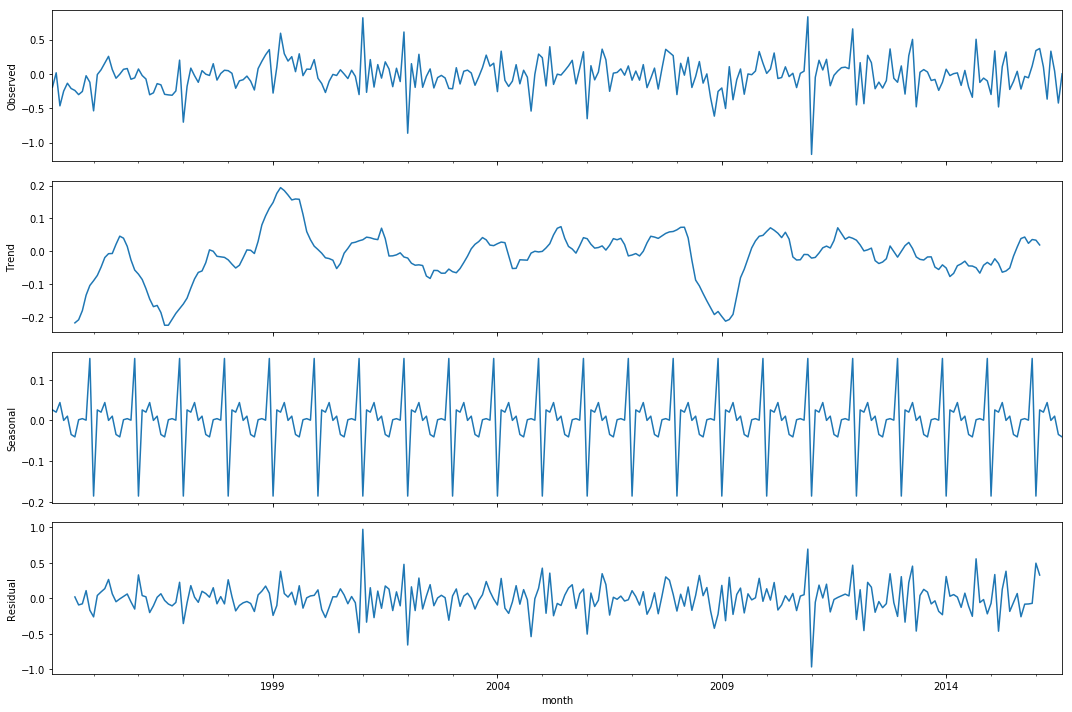

In [17]:
sm.tsa.seasonal_decompose(dataset['diff2']).plot() 

In [18]:
#Теперь ряд стационарен. P value Дика-Фуллера крайне низок. График тренда напоминает шум. Для модели будем использовать два диференцирования D=1 ; d=1

In [19]:
# Найдем приближения для P,p,Q,q

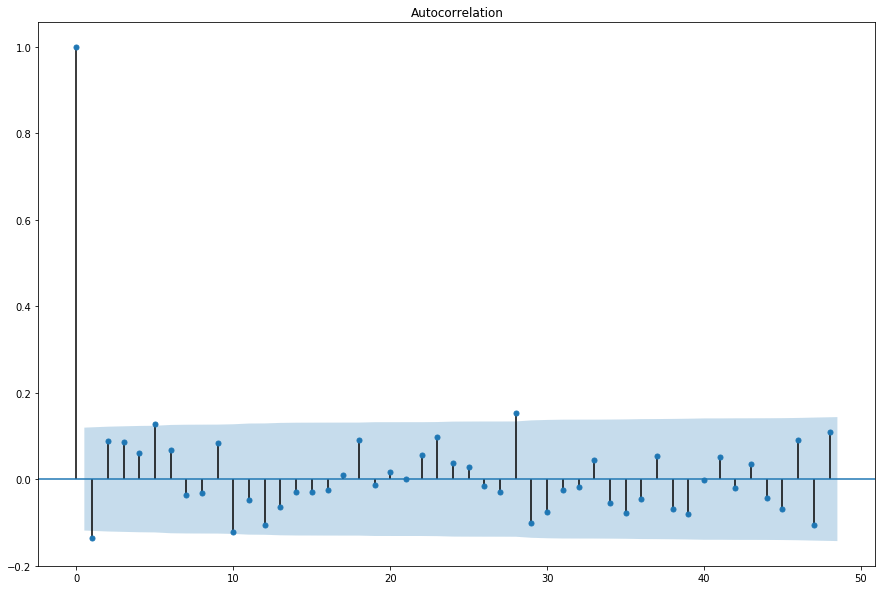

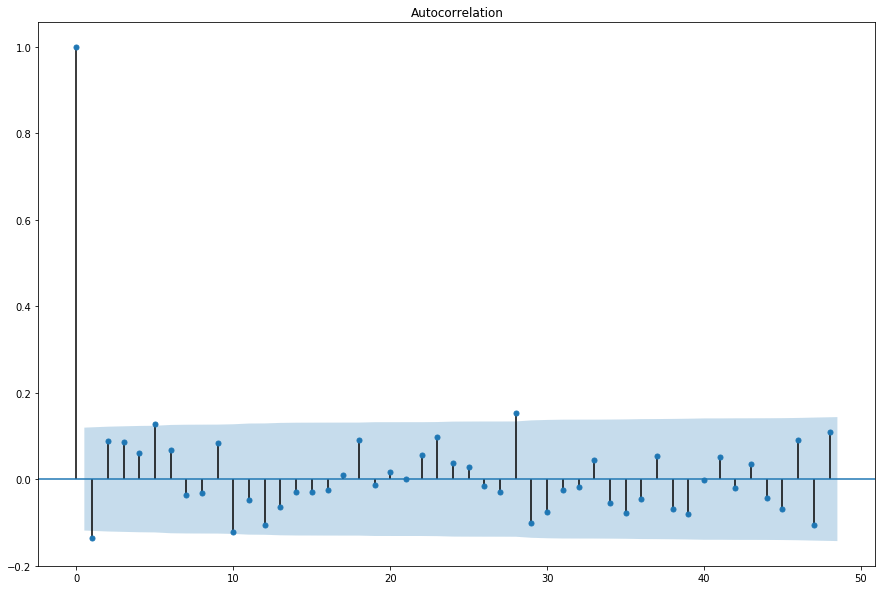

In [20]:
sm.graphics.tsa.plot_acf(dataset['diff2'].values.squeeze(), lags=48)

In [ ]:
# Сезонных пиков автокореляции нет, значит Q=0. q=5, а коллерограме есть еще значимый не сезонный пик на лаге 28, но это слишком большой лаг.

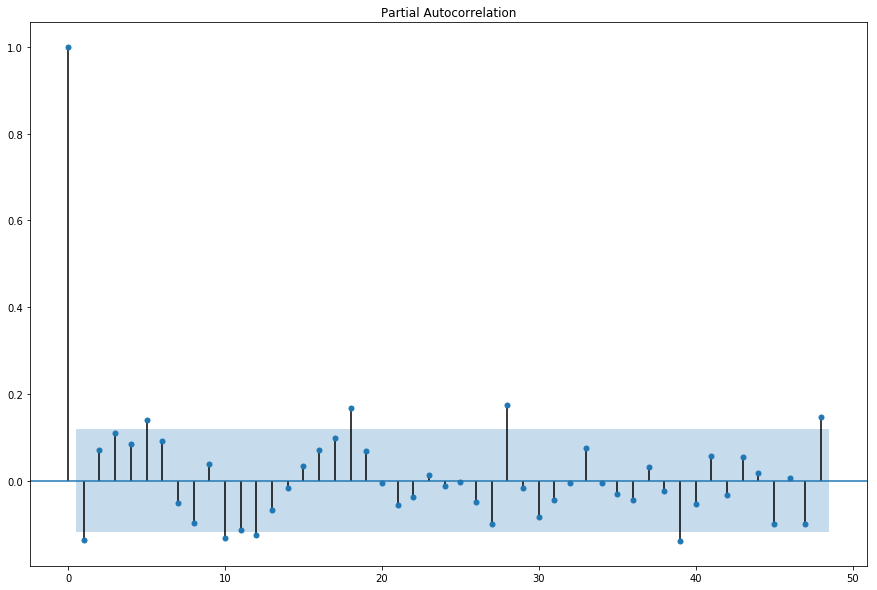

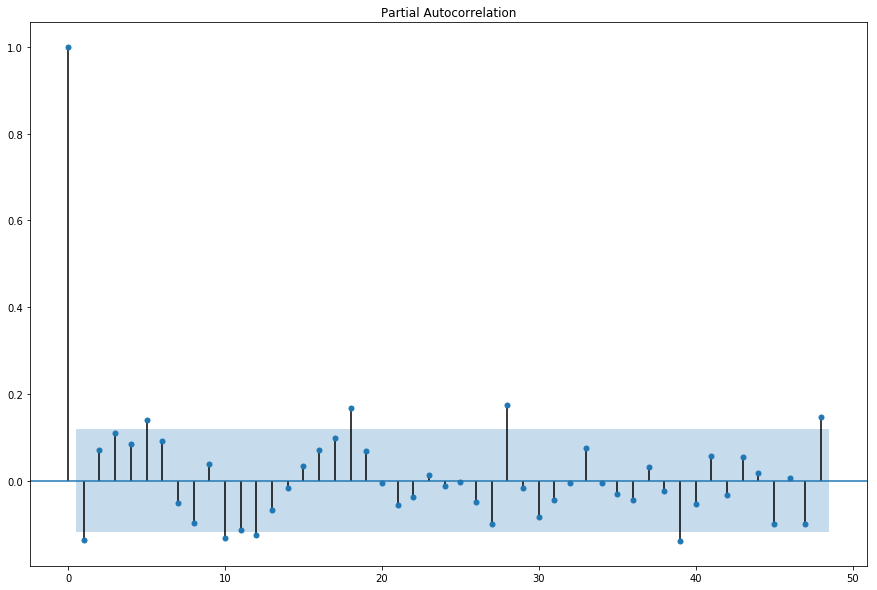

In [21]:
sm.graphics.tsa.plot_pacf(dataset['diff2'].values.squeeze(), lags=48)

In [22]:
# Значисый сезоный лаг приходится на 48, тоесть на 4 годовой сезон. Самый дальний лаг с несезоной коллеряцией (при этом не выступаюзий за пределы сезонности=12) 
#- это 10. Значит: P=4, p=10

In [36]:
ps = range(0, 11)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [37]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

330

In [39]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    try:
        model=sm.tsa.statespace.SARIMAX(dataset.box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 1h 7min 14s


In [41]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
176  (5, 5, 1, 0) -22.088805
173  (5, 4, 3, 0) -21.345933
146  (4, 5, 1, 0) -21.019555
70   (2, 2, 0, 0) -20.542814
76   (2, 3, 1, 0) -20.464318


In [43]:
# Выводим лучшую модель и ее хар-ки
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                box   No. Observations:                  271
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  23.044
Date:                            Thu, 07 May 2020   AIC                            -22.089
Time:                                    11:50:08   BIC                             20.547
Sample:                                02-01-1994   HQIC                            -4.945
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2757      0.211     -1.304      0.192      -0.690       0.139
ar.L2          0.1793      0.151   

In [44]:
# Анализ остатков модели

Критерий Стьюдента: p=0.434404
Критерий Дики-Фуллера: p=0.000000


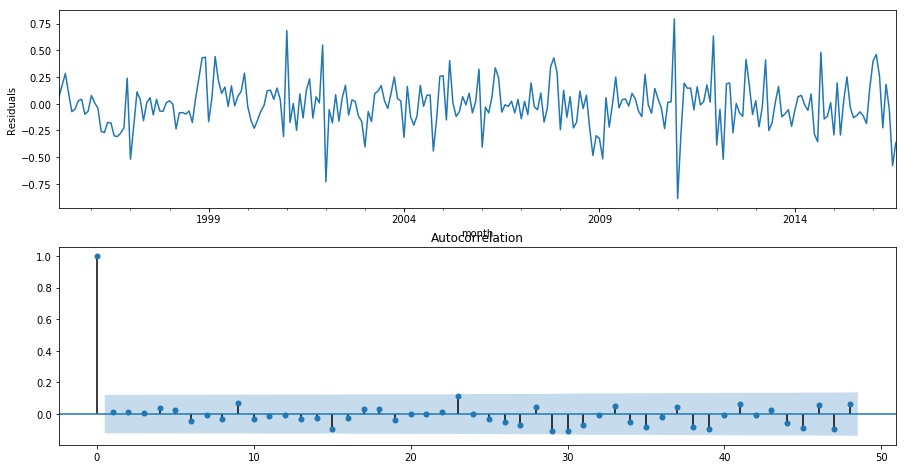

In [46]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [47]:
# Остатки не смещенные, стационарные и не содержат корреляций (совсем не содердат)). Теперь наложим предсказания модели на график реальных данных
# и посмотрим как модель апроксимирует реальную ситуацию.

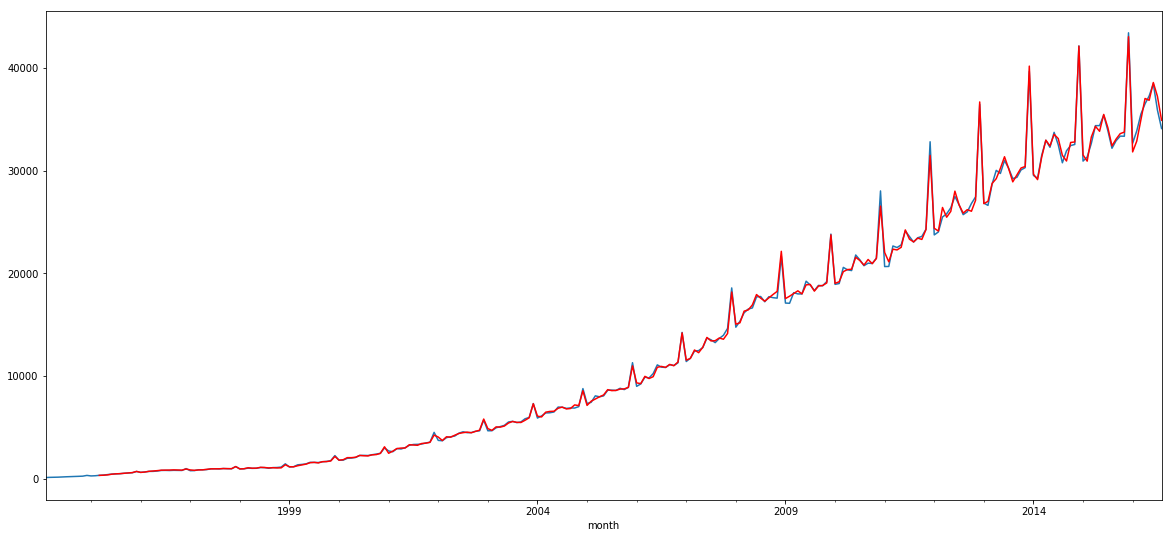

In [49]:
dataset['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(20,9))
dataset.WAG_C_M.plot()
dataset.model[13:].plot(color='r')
pylab.show()

In [50]:
# Выглядит не плохо. Попробуем построить прогноз и сравнить его с реальными данными взятыми на сайте Росстата (зарпата с сентября 2016 по август 2019)

In [53]:
future_income = pd.read_csv('future_income.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [54]:
future_income['forecast'] = invboxcox(best_model.predict(start=271, end=307), lmbda)

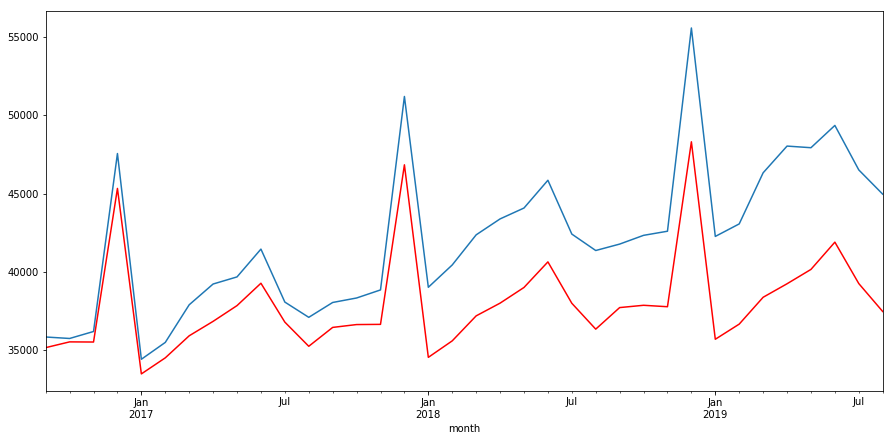

In [56]:
plt.figure(figsize(15,7))
future_income.income.plot()
future_income.forecast.plot(color='r')
pylab.show()

In [57]:
future_income

,income,forecast
month,,
2016-09-01,35843,35164.103936
2016-10-01,35749,35531.702520
2016-11-01,36195,35522.159398
2016-12-01,47554,45327.550799
2017-01-01,34422,33487.475653
2017-02-01,35497,34512.139815
2017-03-01,37899,35919.881592
2017-04-01,39225,36842.006771
2017-05-01,39679,37847.292075


In [ ]:
# Видно что прогноз в целом довольно точно угадывает колебания зарбтной платы. Но современем начинает отставать от повышающегося тренда.
# На горизонте в 3 года отставание прогноза составляет 15% от реальных данных. Но при этом реьеф графика в целом хорошо повторяет реальные данные.
